## Meeting w Ovidiu August 1'st

### (1) Status
* Almost done with forward forecasting
* Hyperparameter tuning running
* Gonna run experiments on different setups

### (2) Experiments:
* Raw features vs PCA vs PLS
* 1 vs all Crops
* CNN vs LSTM Encoders
* All data vs only climate observations
* Correlation Thresholds: 0.05 - 0.2
* for 1 epoch feed in real model, and 1 epoch feed in climate model so it regularises -->> Learn to have bigger margins on some of the climate data

### (3) Tailoring the TFT Architecture:
* Approach: Implement on top of the Pytorch Forecast BaseModel class and swap modules as needed
* Ideas:
    * CNN encoder instead of LSTM
    * Remove temporal decoder masking
    * Feed in final outputs (e.g. 1-period RNN'ish) 
    * Embedding Lontitude and Latitude in D_lon X D_lat dimensions
    * Swap GRN with standard GRU using
    * Connect static Covariates to post-attention feed-forward

### (4) Other
* Requirements for coding style, standards etc. 
    * Keep it clean, have path configuration in 1 block
    * Clearly comment on the files
* Any catch up with Anandha needed?
* Second marker should just meet


In [1]:
import os
import sys
import pandas as pd
sys.path.append("..")
sys.path.append(".")
cwd = os.getcwd()
sys.path.insert(0, cwd)
from src.h_utils import *
from src.h_ptf import *

prices = {
    'wheat_spring': 215.2,
    'wheat_winter': 215.2,
    'soy': 405.9,
    'rice': 268.4,
    'maize': 176.0
}

SCENARIO = 'ssp126'
CLIMATE_MODEL = 'MIROC6'
PRED_YEAR = '2050'
CROPS = ['wheat_winter', 'rice']
import os

model_name = 'test_prediction_1year'
path = 'c:\\Users\\Andreas Langholz\\Yieldcaster' + '/models/' + model_name

model_dict = pickl_load(path)
model = model_dict.get('model')
data = model_dict.get('data')
timeseries = model_dict.get('timeseries')

mp = modelPredictor(model, timeseries, CROPS, CLIMATE_MODEL, SCENARIO)

df_pred = mp.get_next_df()

max_prediction_length = 8
max_encoder_length = 18
cutoff = 2008
time_idx='year'
target='yield'
group_ids=["crop", "pixel_id", "sim"]
static_categoricals=["crop", "pixel_id", "sim"]
static_reals=["lon", "lat", "harvest"]
groups=["crop", "pixel_id", "sim"]
            
columns = df_pred.columns
reals = [col for col in columns if col not in ['lon', 'lat', 'yield','crop', 'year', 'harvest','sim', 'pixel_id']]

parameters = dict(
    time_idx=time_idx,
    target=target,
    group_ids=group_ids,
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length, # Always project MAX_PRD_LEN into validation set
    max_prediction_length=max_prediction_length,
    static_categoricals=static_categoricals,
    static_reals=static_reals,
    time_varying_known_reals=reals,        
    target_normalizer=GroupNormalizer(
        groups=groups, 
        transformation="softplus"
    ), 
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)     



c:\Users\Andreas Langholz\Yieldcaster\newvenv\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


: 

: 

In [2]:

ts = TimeSeriesDataSet.from_parameters(parameters, df_pred, predict = True)        
pred_load = ts.to_dataloader(train=False, batch_size=32, num_workers=4)

pred, p_x, p_index = model.predict(ts, mode="prediction", return_index = True, return_x=True, show_progress_bar = True)
raw_predictions, raw_x = model.predict(pred_load, mode="raw", return_x=True, show_progress_bar = True)



c:\Users\Andreas Langholz\Yieldcaster\newvenv\lib\site-packages\pytorch_forecasting\data\encoders.py:855: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
c:\Users\Andreas Langholz\Yieldcaster\newvenv\lib\site-packages\pytorch_forecasting\data\timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 34 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__crop': 'rice', '__group_id__pixel_id': '15191', '__group_id__sim': 'Y'}, {'__group_id__crop': 'rice', '__group_id__pixel_id': '20183', '__group_id__sim': 'Y'}, {'__group_id__crop': 'rice', '__group_id__pixel_id': '20427', '__group_id__sim': 'Y'}, {'__group_id__crop': 'rice', '__group_id__pixel_id': '21432', '__group_id__sim': 'Y'}, {'__group_id__crop': 'ri

Predict:   0%|          | 0/233 [00:00<?, ? batches/s]

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x306 with 1 Axes>,
 'encoder_variables': <Figure size 504x1800 with 1 Axes>,
 'decoder_variables': <Figure size 504x1800 with 1 Axes>}

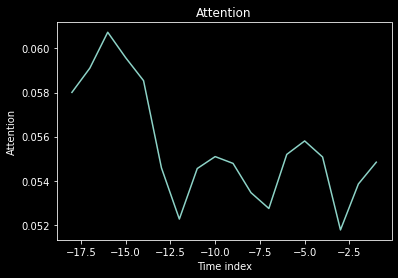

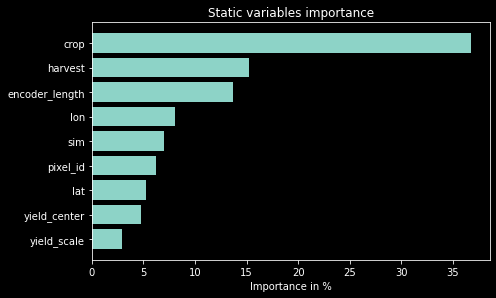

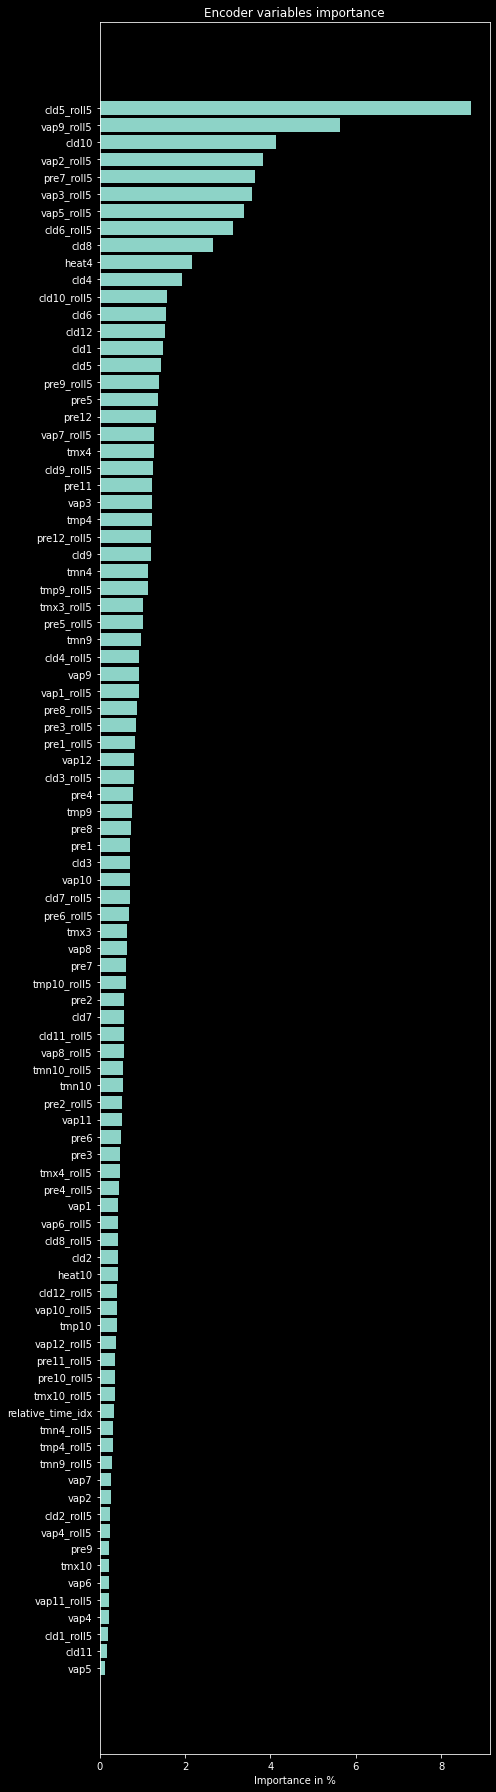

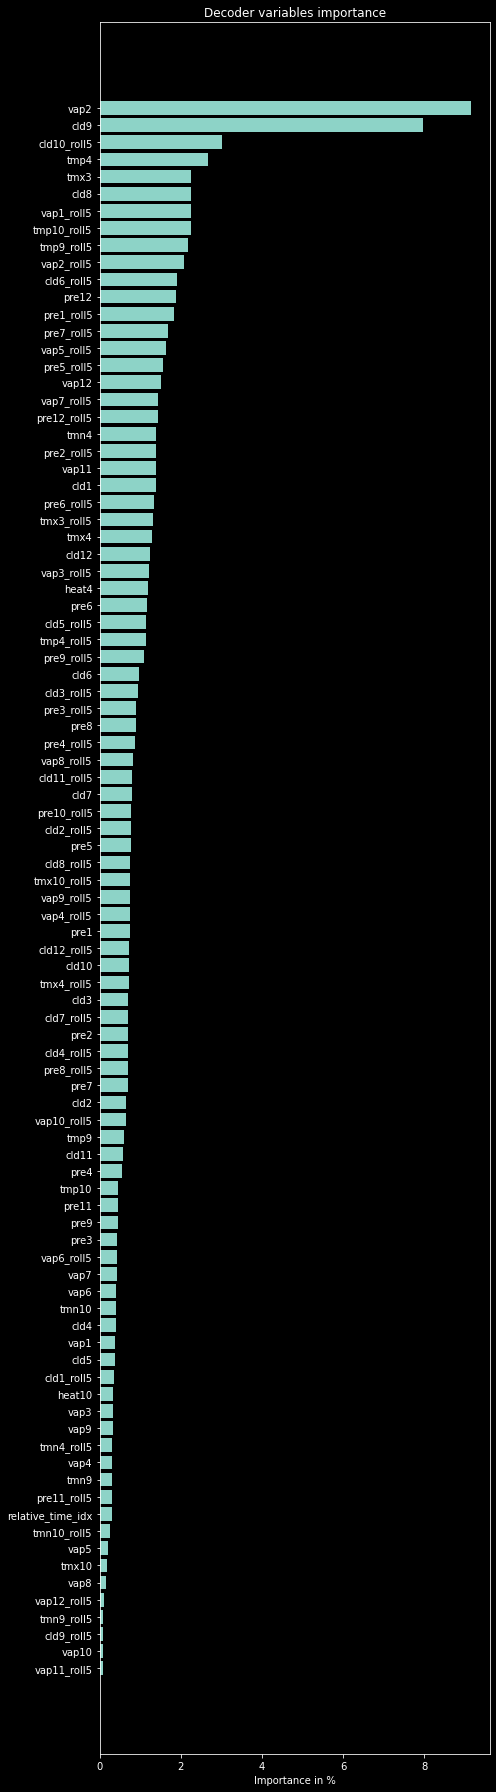

In [6]:
interpretation = model.interpret_output(raw_predictions, reduction="sum")
model.plot_interpretation(interpretation)

In [1]:
for idx in range(1000,1020):  # plot 10 examples
    model.plot_prediction(raw_x, raw_predictions, idx=idx, show_future_observed=False);

NameError: name 'model' is not defined